In [ ]:
%pip install -q amplpy
from amplpy import AMPL, ampl_notebook
ampl = ampl_notebook(
    modules=["highs"], # install HiGHS
    license_uuid="c6feb3b0-91be-42a2-ac0f-680b62ad5008")
    # your license UUID (e.g., free ampl.com/ce or ampl.com/courses licenses)

In [ ]:
import pandas as pd
solar_gen=pd.read_csv('data/solar1.csv',header=None,skiprows=4, index_col=None)
solar_gen.drop(columns=[0,1],inplace=True)
# reset the index to start from 0
solar_gen.reset_index(drop=True,inplace=True)
print(solar_gen.head(10))

# add wind 
wind_gen=pd.read_csv('data/wind1.csv',header=None,skiprows=4, index_col=None)
wind_gen.drop(columns=[0,1,3],inplace=True)
# reset the index to start from 0
wind_gen.reset_index(drop=True,inplace=True)
print(wind_gen.head(10))


Optimal Solar Capacity: 1233022.92154894
Optimal Wind Capacity: 264051.958486775
Optimal Nuclear Capacity: 2922.46056993639
Optimal Gas Capacity: 4507.66136185694
Total Cost: 8445200938799308.0


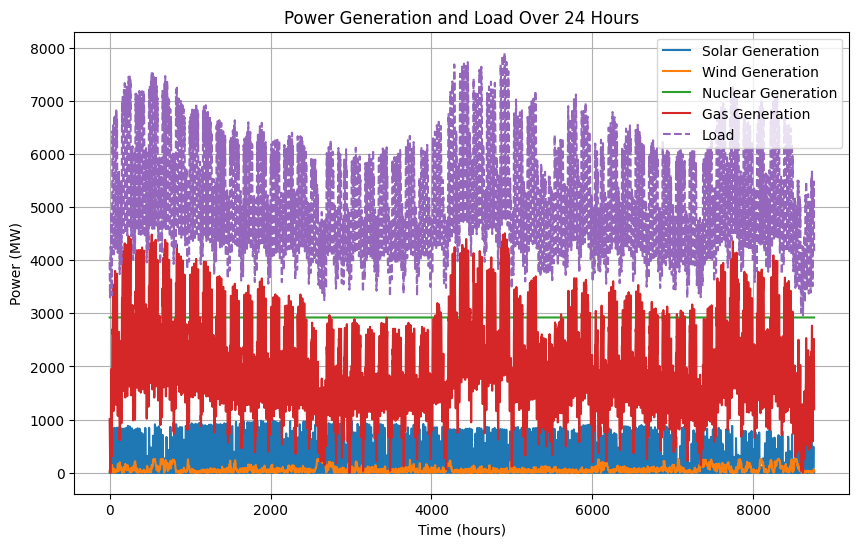

In [13]:
import pandas as pd
import pyomo.environ as pyo
import matplotlib.pyplot as plt

# Load demand data
l_t = list(range(24*365))
load = pd.read_excel('dades_dem_cat.xlsx', sheet_name="Full2", header=None, index_col=0)
Pload = {t: float(load[1][t+1]) for t in l_t}

# Load solar generation data
solar_gen = pd.read_csv('data/solar1.csv', header=None, skiprows=4, index_col=None)
solar_gen.drop(columns=[0, 1], inplace=True)
solar_gen.reset_index(drop=True, inplace=True)
solar_gen=solar_gen/1000
# Load wind generation data
wind_gen = pd.read_csv('data/wind1.csv', header=None, skiprows=4, index_col=None)
wind_gen.drop(columns=[0, 1, 3], inplace=True)
wind_gen.reset_index(drop=True, inplace=True)
wind_gen=wind_gen/1000

# Define the model
model = pyo.ConcreteModel()

# Define sets
model.T = pyo.Set(initialize=l_t)

# Define parameters
model.Pload = pyo.Param(model.T, initialize=Pload)
model.solar_gen = pyo.Param(model.T, initialize={t: solar_gen.iloc[t, 0] for t in l_t})
model.wind_gen = pyo.Param(model.T, initialize={t: wind_gen.iloc[t, 0] for t in l_t})

# Define variables
model.Psolar = pyo.Var(within=pyo.NonNegativeReals)
model.Pwind = pyo.Var(within=pyo.NonNegativeReals)
model.Pnuc = pyo.Var(within=pyo.NonNegativeReals)
model.Ppgas = pyo.Var(within=pyo.NonNegativeReals)
model.Pgas_t = pyo.Var(model.T, within=pyo.NonNegativeReals)
# model.Psolar_t = pyo.Var(model.T, within=pyo.NonNegativeReals)
# model.Pwind_t = pyo.Var(model.T, within=pyo.NonNegativeReals)

# Objective function: Minimize the total cost
def func_obj(m):
    CAPEX_nuc = m.Pnuc * 3600 * 10**3
    OPEX_nuc = m.Pnuc * 90 * 10**3 * 365
    CAPEX_gas = m.Ppgas * 823 * 10**3
    OPEX_gas = sum(m.Pgas_t[t] * 1 for t in l_t) * 365 * 25 * 10**3
    CAPEX_solar = m.Psolar * 900 * 10**3
    OPEX_solar = (m.Psolar * 365 * 15 * 10**3) / 2
    CAPEX_wind = m.Pwind * 1300 * 10**3
    OPEX_wind = (m.Pwind * 365 * 35 * 10**3) / 2
    return (CAPEX_nuc + OPEX_nuc * 50 + CAPEX_gas + OPEX_gas * 50 +
            CAPEX_solar + OPEX_solar * 50 + CAPEX_wind + OPEX_wind * 50)
model.TotalCost = pyo.Objective(rule=func_obj, sense=pyo.minimize)

# Constraints
# Gas size constraint
def gas_size_constraint_rule(m, t):
    return m.Pgas_t[t] <= m.Ppgas
model.GasSizeConstraint = pyo.Constraint(model.T, rule=gas_size_constraint_rule)


def demand_constraint_rule(m, t):
    return (m.Psolar * m.solar_gen[t] +
            m.Pwind * m.wind_gen[t] +
            m.Pnuc +
            m.Pgas_t[t] == m.Pload[t])
model.DemandConstraint = pyo.Constraint(model.T, rule=demand_constraint_rule)


# # Solar size constraint
# def solar_size_constraint_rule(m, t):
#     return m.Psolar_t[t] <= m.solar_gen[t] * m.Psolar
# model.SolarSizeConstraint = pyo.Constraint(model.T, rule=solar_size_constraint_rule)

# # Wind size constraint
# def wind_size_constraint_rule(m, t):
#     return m.Pwind_t[t] <= m.wind_gen[t] * m.Pwind
# model.WindSizeConstraint = pyo.Constraint(model.T, rule=wind_size_constraint_rule)

# Solve the problem
solver = pyo.SolverFactory('glpk')
solver.solve(model)

# Print the results
print(f"Optimal Solar Capacity: {pyo.value(model.Psolar)}")
print(f"Optimal Wind Capacity: {pyo.value(model.Pwind)}")
print(f"Optimal Nuclear Capacity: {pyo.value(model.Pnuc)}")
print(f"Optimal Gas Capacity: {pyo.value(model.Ppgas)}")
print(f"Total Cost: {pyo.value(model.TotalCost)}")

# Extract the results
Psolar = pyo.value(model.Psolar)
Pwind = pyo.value(model.Pwind)
Pnuc = pyo.value(model.Pnuc)
Pgas_t = [pyo.value(model.Pgas_t[t]) for t in l_t]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(l_t, [Psolar * solar_gen.iloc[t, 0] for t in l_t], label='Solar Generation')
plt.plot(l_t, [Pwind * wind_gen.iloc[t, 0] for t in l_t], label='Wind Generation')
plt.plot(l_t, [Pnuc] * len(l_t), label='Nuclear Generation')
plt.plot(l_t, Pgas_t, label='Gas Generation')
plt.plot(l_t, [Pload[t] for t in l_t], label='Load', linestyle='--')

plt.xlabel('Time (hours)')
plt.ylabel('Power (MW)')
plt.title('Power Generation and Load Over 24 Hours')
plt.legend()
plt.grid(True)
plt.show()